<h1 style="text-align: center;">Statistical Methods for Machine Learning</h1>
<h1 style="text-align: center;">"Cats and Dogs classification"</h1>

### Importing Libraries and Modules

In [1]:
import shutil
import pandas as pd
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Data folder preparation

This code cell organizes cat and dog images, creating a 'data' folder and renaming the files with a '0' (Cats) or '1' (Dogs) prefix.


In [1]:
data_path = r'C:\Users\lucad\OneDrive\Desktop\MACHINE LEARNING\data'

# Creating the data folder if it doesn't already exist
if not os.path.exists(data_path):
    os.makedirs(data_path)

for filename in os.listdir(r'C:\Users\lucad\OneDrive\Desktop\MACHINE LEARNING\dataset\CatsDogs\dogs'):
    if filename.endswith('.jpg'):
        shutil.copy(os.path.join(r'C:\Users\lucad\OneDrive\Desktop\MACHINE LEARNING\dataset\CatsDogs\dogs', filename), os.path.join(data_path, '1' + filename))

for filename in os.listdir(r'C:\Users\lucad\OneDrive\Desktop\MACHINE LEARNING\dataset\CatsDogs\cats'):
    if filename.endswith('.jpg'):
        shutil.copy(os.path.join(r'C:\Users\lucad\OneDrive\Desktop\MACHINE LEARNING\dataset\CatsDogs\cats', filename), os.path.join(data_path, '0' + filename))


Checking if all the 25000 images have correctly populated the data folder.

In [2]:
data_dir = r'C:\Users\lucad\OneDrive\Desktop\MACHINE LEARNING\data'

num_data = len([f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))])
print(f"There are {num_data} files in the folder {data_dir}")

There are 25000 files in the folder C:\Users\lucad\OneDrive\Desktop\MACHINE LEARNING\data


### Loading, Preprocessing, and Splitting Data

Here I load and resize images to **150x150 pixels**, converts them to to NumPy arrays with **RGB channels**, **rescales** pixel values between 0 and 1, and splits the data into **train** and **test** sets.  

Two images are not loeaded because they were corrupted.


In [3]:
# Load the images and convert them to arrays
images = []
labels = []
for file in os.listdir(data_dir):
    if file.startswith('0'):
        label = 0  # cat
    else:
        label = 1  # dog
    try:
        img = load_img(os.path.join(data_dir, file), target_size=(150, 150))
    except:
        print("Cannot open image file:", file)
        continue
    img_array = img_to_array(img)
    img_array = img_array / 255.0  
    images.append(img_array)
    labels.append(label)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

Cannot open image file: 0666.jpg
Cannot open image file: 111702.jpg


C:\Users\lucad\anaconda3\anaconda\envs\tensorflow\lib\site-packages\PIL\TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Here I created the validation set by splitting the training set.

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

### Inspecting the Data
Before feeding the data to the models, I check that the data has been preprocessed correctly.

In [5]:
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))
print(len(X_test))
print(len(y_test))

14998
14998
5000
5000
5000
5000


In [6]:
print("Numero di immagini:", len(images))
print("Numero di etichette:", len(labels))

Numero di immagini: 24998
Numero di etichette: 24998


Display 16 random images

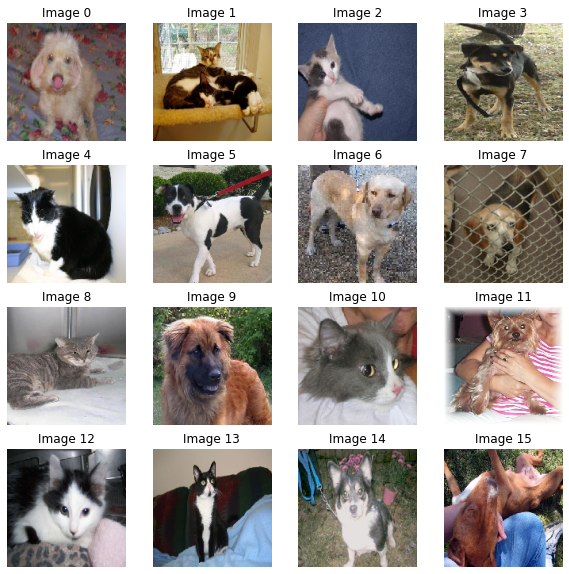

In [7]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

random_images = random.sample(images, 16)

for i in range(4):
    for j in range(4):
        axs[i, j].imshow(random_images[i*4 + j])
        axs[i, j].axis('off')
        axs[i, j].set_title(f'Image {i*4 + j}')

plt.show()


In [8]:
# Convert the lists to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)


# Verify the shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (14998, 150, 150, 3)
y_train shape: (14998,)
X_val shape: (5000, 150, 150, 3)
y_val shape: (5000,)
X_test shape: (5000, 150, 150, 3)
y_test shape: (5000,)


## 1st experiment: model1
`model1` is a very simple convolutional neural network (CNN). 

**Conv2D layers**: These are the convolutional layers that learn to extract features from the input images. The first layer has 32 filters, while the following layers have 64 and 128 filters. The filter size is (3, 3) for all layers, and the activation function used is 'relu', which introduces nonlinearity and helps the network learn more complex patterns.

**MaxPooling2D layers**: These layers perform downsampling, reducing the spatial dimensions of the feature maps. This helps reduce the number of parameters in the model and thus reduces computational cost, while also improving the model's ability to recognize features in different scales and translations.

**Flatten layer**: This layer reshapes the output of the previous MaxPooling2D layer into a one-dimensional tensor, so it can be fed into the dense layers.

**Dense layers**: These are fully connected layers that perform classification based on the extracted features. The first dense layer has 512 units with 'relu' activation. The last dense layer has only one unit with 'sigmoid' activation, which outputs the probability of the image being a dog (dog=1).

**Model compilation**: The model is compiled using the 'adam' optimizer, which is an adaptive learning rate optimization algorithm. It adjusts the learning rate during training, making it a popular choice for training neural networks. The loss function used is 'binary_crossentropy', which is suitable for binary classification problems (I will use zero-one loss only in the final cross validation). 

In [22]:
# Model architecture
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/20
469/469 [==============================] - 218s 459ms/step - loss: 1.3881 - accuracy: 0.5798 - val_loss: 0.6273 - val_accuracy: 0.6548
Epoch 2/20
469/469 [==============================] - 210s 447ms/step - loss: 0.5795 - accuracy: 0.6982 - val_loss: 0.5813 - val_accuracy: 0.6904
Epoch 3/20
469/469 [==============================] - 208s 443ms/step - loss: 0.5147 - accuracy: 0.7464 - val_loss: 0.5144 - val_accuracy: 0.7526
Epoch 4/20
469/469 [==============================] - 211s 449ms/step - loss: 0.4674 - accuracy: 0.7809 - val_loss: 0.4886 - val_accuracy: 0.7872
Epoch 5/20
469/469 [==============================] - 214s 455ms/step - loss: 0.4111 - accuracy: 0.8137 - val_loss: 0.4995 - val_accuracy: 0.7710
Epoch 6/20
469/469 [==============================] - 213s 454ms/step - loss: 0.3567 - accuracy: 0.8442 - val_loss: 0.4265 - val_accuracy: 0.8056
Epoch 7/20
469/469 [==============================] - 221s 472ms/step - loss: 0.3092 - accuracy: 0.8707 - val_loss: 0.4984 -

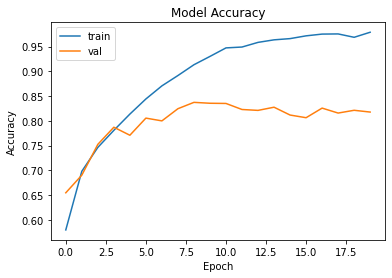

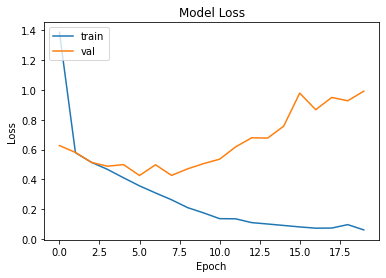

157/157 [==============================] - 18s 114ms/step - loss: 0.9578 - accuracy: 0.8204
Test accuracy: 0.8203999996185303


In [29]:
# Train the model
history1 = model1.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Plot the training and validation accuracy over epochs
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model1.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


### Comments on model1 performances
The model exhibits significant overfitting as it achieves a high training accuracy of 97.9% but a much lower validation accuracy of 83.74%. The increasing validation loss after the 6th epoch, while training loss continues to decrease, indicates the model is fitting the training data too closely and struggles to generalize to new, unseen data. Addressing overfitting is crucial to improve the model's performance on real-world data.

## 2nd experiment: model2
`model2` adds a Dropout layer, which combats overfitting by randomly disabling 50% of input units during training, encouraging the model to learn more generalizable features.

In [31]:
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),  # Add dropout layer
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



Epoch 1/20
469/469 [==============================] - 302s 643ms/step - loss: 1.0479 - accuracy: 0.5339 - val_loss: 0.6731 - val_accuracy: 0.5746
Epoch 2/20
469/469 [==============================] - 286s 610ms/step - loss: 0.6847 - accuracy: 0.5539 - val_loss: 0.6877 - val_accuracy: 0.5384
Epoch 3/20
469/469 [==============================] - 290s 619ms/step - loss: 0.6832 - accuracy: 0.5583 - val_loss: 0.6784 - val_accuracy: 0.5696
Epoch 4/20
469/469 [==============================] - 301s 642ms/step - loss: 0.6978 - accuracy: 0.5397 - val_loss: 0.6909 - val_accuracy: 0.5322
Epoch 5/20
469/469 [==============================] - 298s 636ms/step - loss: 0.6883 - accuracy: 0.5329 - val_loss: 0.6807 - val_accuracy: 0.5552
Epoch 6/20
469/469 [==============================] - 283s 604ms/step - loss: 0.6835 - accuracy: 0.5547 - val_loss: 0.6969 - val_accuracy: 0.5104
Epoch 7/20
469/469 [==============================] - 289s 615ms/step - loss: 0.6922 - accuracy: 0.5245 - val_loss: 0.6898 -

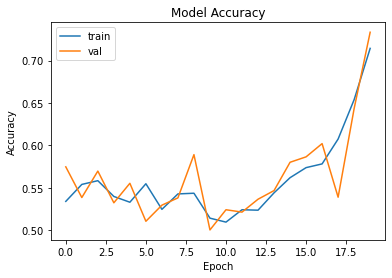

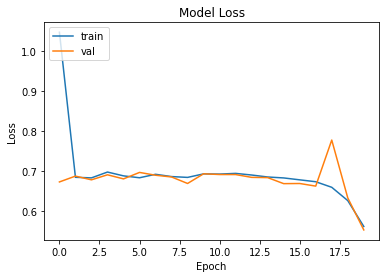

157/157 [==============================] - 19s 123ms/step - loss: 0.5551 - accuracy: 0.7354
Test accuracy: 0.7354000210762024


In [32]:
history2 = model2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

test_loss, test_acc = model2.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

### Comments on model2 performances
The second model has a lower training accuracy (71.44%) and validation accuracy (73.34%) compared to the first model. However, the smaller gap between the training and validation accuracies indicates a reduced overfitting issue. 


## 3rd experiment: model3
`model3` is similar to the second model but modifies the Dropout layer. Instead of dropping 50% of input units during training, it drops 30%. This change aims to strike a balance between preventing overfitting and retaining enough information for the model to learn effectively.


In [33]:
model3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.3),  # Add dropout layer
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Epoch 1/25
469/469 [==============================] - 246s 524ms/step - loss: 0.6501 - accuracy: 0.6136 - val_loss: 0.5958 - val_accuracy: 0.6828
Epoch 2/25
469/469 [==============================] - 234s 499ms/step - loss: 0.5834 - accuracy: 0.6922 - val_loss: 0.5627 - val_accuracy: 0.7226
Epoch 3/25
469/469 [==============================] - 237s 505ms/step - loss: 0.5475 - accuracy: 0.7213 - val_loss: 0.5254 - val_accuracy: 0.7380
Epoch 4/25
469/469 [==============================] - 238s 507ms/step - loss: 0.4980 - accuracy: 0.7614 - val_loss: 0.4542 - val_accuracy: 0.7850
Epoch 5/25
469/469 [==============================] - 242s 516ms/step - loss: 0.4542 - accuracy: 0.7860 - val_loss: 0.4515 - val_accuracy: 0.7868
Epoch 6/25
469/469 [==============================] - 241s 513ms/step - loss: 0.4021 - accuracy: 0.8145 - val_loss: 0.4015 - val_accuracy: 0.8236
Epoch 7/25
469/469 [==============================] - 247s 527ms/step - loss: 0.3682 - accuracy: 0.8359 - val_loss: 0.3741 -

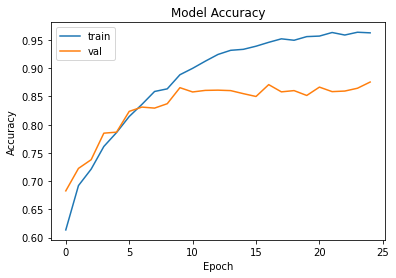

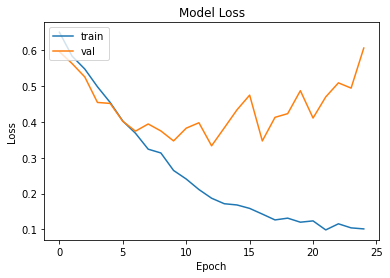

157/157 [==============================] - 20s 129ms/step - loss: 0.4970 - accuracy: 0.8760
Test accuracy: 0.8759999871253967


In [35]:
history3 = model3.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val))

plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

test_loss, test_acc = model3.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

### Comments on model3 performances
The third model demonstrates better performance compared to the previous models. The validation accuracy reached 87.56% while the training accuracy reached 96.27%, indicating a smaller gap between the two than in `model1`.

However, it's important to note that starting from Epoch 11, the validation loss starts to increase, indicating that the model is still overfitting to some extent. To further improve the model I will consider additional regularization techniques or architectural changes, and I will let the training stop depending on the improvements.


## 4th experiment: model4
`model4` introduces several changes compared to the previous model:

1. **Additional Dropout layers**: In model4, Dropout layers are added after each Conv2D-MaxPooling2D block, with dropout rates of 10%, 20%, and 30% respectively. These additional Dropout layers help to further reduce overfitting by randomly disabling input units during training, which encourages the model to learn more generalizable features.

2. **Early Stopping**: An EarlyStopping callback is used during training, monitoring the validation loss with a patience of 3 epochs. This means that the training will stop if there is no improvement in validation loss for 3 consecutive epochs. The best weights, corresponding to the lowest validation loss, will be restored to the model at the end of training. 


In [39]:
model4 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.1), 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2), 
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3), 
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3), 
    Dense(1, activation='sigmoid')
])

model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)



Epoch 1/25
469/469 [==============================] - 374s 795ms/step - loss: 5.2986 - accuracy: 0.5081 - val_loss: 0.6927 - val_accuracy: 0.5076
Epoch 2/25
469/469 [==============================] - 376s 802ms/step - loss: 0.6916 - accuracy: 0.5181 - val_loss: 0.6930 - val_accuracy: 0.5100
Epoch 3/25
469/469 [==============================] - 363s 774ms/step - loss: 0.6909 - accuracy: 0.5233 - val_loss: 0.6923 - val_accuracy: 0.5188
Epoch 4/25
469/469 [==============================] - 360s 767ms/step - loss: 0.6901 - accuracy: 0.5325 - val_loss: 0.6925 - val_accuracy: 0.5162
Epoch 5/25
469/469 [==============================] - 364s 777ms/step - loss: 0.6851 - accuracy: 0.5456 - val_loss: 0.6939 - val_accuracy: 0.5284
Epoch 6/25
469/469 [==============================] - 340s 726ms/step - loss: 0.6845 - accuracy: 0.5405 - val_loss: 0.6906 - val_accuracy: 0.5534
Epoch 7/25
469/469 [==============================] - 375s 799ms/step - loss: 0.6830 - accuracy: 0.5419 - val_loss: 0.6940 -

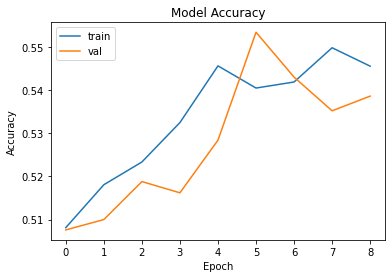

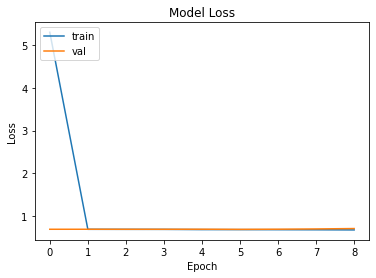

157/157 [==============================] - 17s 109ms/step - loss: 0.6826 - accuracy: 0.5512
Test accuracy: 0.5511999726295471


In [40]:
history4 = model4.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

test_loss, test_acc = model4.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

### Comments on model4 performances

The model is struggling to learn the underlying patterns in the data as evidenced by the slow decrease in training loss and  high and inconsistent validation loss. Although there is no overfitting, the poor overall performance suggests that the model is underfitting the data: worst performance until now.


## 5th experiment: model5

The `model5` architecture introduces several changes compared to `model4`:

1. **Batch Normalization**: In this new model, Batch Normalization layers are added after each Conv2D layer and before the Dense layer. These layers help normalize the inputs to each layer, which can speed up the training process and improve generalization.

2. **Activation functions**: Instead of including the activation functions directly within the Conv2D and Dense layers, they are now separated into individual Activation layers. This allows Batch Normalization to be applied before the activation functions.

3. **Dropout rate**: The dropout rate has been changed to a constant value of 0.2 for all Dropout layers, which is a more moderate rate compared to the previous model. 

4. **Learning rate**: The learning rate for the Adam optimizer has been set to 0.0005, which is a smaller value compared to the default learning rate. This can help the model converge more steadily, potentially leading to better performance.


In [41]:
dropout_rate = 0.2
learning_rate = 0.0005

model5 = Sequential([
    Conv2D(32, (3, 3), input_shape=(150, 150, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(128, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Flatten(),
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

model5.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)



Epoch 1/25
469/469 [==============================] - 423s 895ms/step - loss: 0.6075 - accuracy: 0.6869 - val_loss: 0.6293 - val_accuracy: 0.6762
Epoch 2/25
469/469 [==============================] - 431s 918ms/step - loss: 0.4926 - accuracy: 0.7627 - val_loss: 0.5514 - val_accuracy: 0.7254
Epoch 3/25
469/469 [==============================] - 429s 915ms/step - loss: 0.4323 - accuracy: 0.7992 - val_loss: 0.5199 - val_accuracy: 0.7504
Epoch 4/25
469/469 [==============================] - 405s 864ms/step - loss: 0.3763 - accuracy: 0.8326 - val_loss: 0.4275 - val_accuracy: 0.8044
Epoch 5/25
469/469 [==============================] - 430s 917ms/step - loss: 0.3226 - accuracy: 0.8614 - val_loss: 0.4245 - val_accuracy: 0.8182
Epoch 6/25
469/469 [==============================] - 1615s 3s/step - loss: 0.2800 - accuracy: 0.8805 - val_loss: 0.4411 - val_accuracy: 0.8040
Epoch 7/25
469/469 [==============================] - 311s 663ms/step - loss: 0.2263 - accuracy: 0.9079 - val_loss: 0.3963 - v

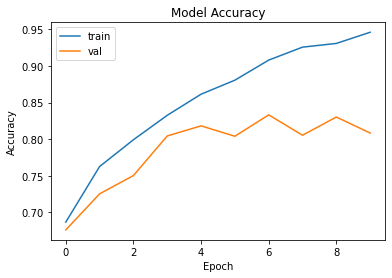

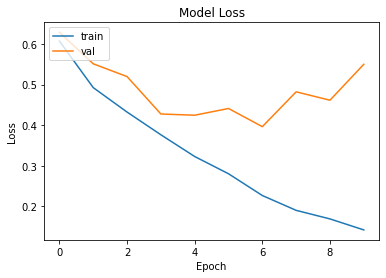

157/157 [==============================] - 22s 138ms/step - loss: 0.3905 - accuracy: 0.8382
Test accuracy: 0.8381999731063843


In [42]:
history5 = model5.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


test_loss, test_acc = model5.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

### Comments on model5 performances

`model5` is back on track! However, even if it has shown a huge improvement in performance compared to `model5`it is not the best model I trained so far. Its training loss decreases consistently over epochs, while the validation loss increases after epoch 7. This model exhibits overfitting as the training accuracy is much higher than the validation accuracy and there is space for improvements.


### 6th experiment: model6
The `model6` introduces several modifications compared to the previous model:

1. **Reduced dropout rate**: The dropout rate is reduced to 0.1.
2. **L2 regularization**: L2 regularization (with a lambda of 0.001) is added to the convolutional and dense layers, which helps prevent overfitting by penalizing large weights in the model.
3. **Data augmentation**: The training data is augmented using rotation, width and height shifts, horizontal flips, and zoom. This increases the diversity of the training data and helps the model generalize better to unseen data.
4. **Increased dropout rate after third convolutional layer**: A higher dropout rate of 0.5 is applied after the third convolutional layer to reduce overfitting on deeper layers.


In [59]:
dropout_rate = 0.1
learning_rate = 0.0005
l2_lambda = 0.001

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_data = train_datagen.flow(X_train, y_train)

model6 = Sequential([
    Conv2D(32, (3, 3), kernel_regularizer=l2(l2_lambda), input_shape=(150, 150, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(64, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(128, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(512, kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

model6.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


Epoch 1/25
468/468 [==============================] - 518s 1s/step - loss: 1.5760 - accuracy: 0.6400 - val_loss: 1.1943 - val_accuracy: 0.6866
Epoch 2/25
468/468 [==============================] - 466s 996ms/step - loss: 1.0056 - accuracy: 0.6919 - val_loss: 0.8786 - val_accuracy: 0.7198
Epoch 3/25
468/468 [==============================] - 374s 799ms/step - loss: 0.8565 - accuracy: 0.7057 - val_loss: 1.0854 - val_accuracy: 0.6186
Epoch 4/25
468/468 [==============================] - 362s 774ms/step - loss: 0.7980 - accuracy: 0.7228 - val_loss: 0.7961 - val_accuracy: 0.7154
Epoch 5/25
468/468 [==============================] - 358s 764ms/step - loss: 0.7863 - accuracy: 0.7302 - val_loss: 0.8564 - val_accuracy: 0.7166
Epoch 6/25
468/468 [==============================] - 362s 773ms/step - loss: 0.7635 - accuracy: 0.7444 - val_loss: 0.7148 - val_accuracy: 0.7778
Epoch 7/25
468/468 [==============================] - 358s 765ms/step - loss: 0.7512 - accuracy: 0.7461 - val_loss: 0.9366 - va

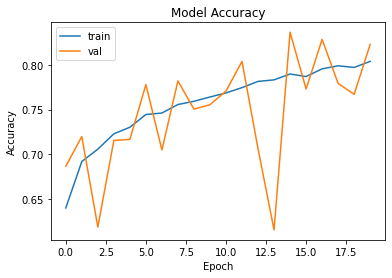

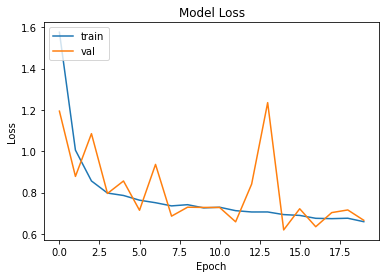

157/157 [==============================] - 22s 139ms/step - loss: 0.6122 - accuracy: 0.8376
Test accuracy: 0.8375999927520752


In [60]:
history6 = model6.fit(train_data, epochs=25, steps_per_epoch=len(X_train) // 32, validation_data=(X_val, y_val), callbacks=[early_stopping])

plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

test_loss, test_acc = model6.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

### Comments on model6 performances

`model6` shows consistent improvement in both training and validation accuracy compared to previous models. Although validation loss increases after epoch 15, overall performance is considerably better. Any overfitting is minimal, thanks to the use of regularization techniques and data augmentation. It's also worth noting that validation accuracy is sometimes higher than training accuracy due to regularization techniques applied only during training and data augmentation.


## Model7: Deeper architecture

`model7` differs from the previous model by adding two more convolutional layers, making the architecture deeper. It also includes an additional Dense layer with 1024 units. These changes aim to improve the model's capacity to learn more complex and hierarchical features.


In [ ]:
dropout_rate = 0.1
learning_rate = 0.0005
l2_lambda = 0.001

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_data = train_datagen.flow(X_train, y_train)

model7 = Sequential([
    Conv2D(32, (3, 3), kernel_regularizer=l2(l2_lambda), input_shape=(150, 150, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(64, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(128, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(256, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(512, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(1024, kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(dropout_rate),
    Dense(512, kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

model7.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Epoch 1/25
468/468 [==============================] - 580s 1s/step - loss: 2.9460 - accuracy: 0.6143 - val_loss: 2.4545 - val_accuracy: 0.5804
Epoch 2/25
468/468 [==============================] - 526s 1s/step - loss: 1.8672 - accuracy: 0.6927 - val_loss: 1.4847 - val_accuracy: 0.6734
Epoch 3/25
468/468 [==============================] - 539s 1s/step - loss: 1.1954 - accuracy: 0.7275 - val_loss: 1.0493 - val_accuracy: 0.7208
Epoch 4/25
468/468 [==============================] - 536s 1s/step - loss: 0.8722 - accuracy: 0.7518 - val_loss: 0.7990 - val_accuracy: 0.7444
Epoch 5/25
468/468 [==============================] - 516s 1s/step - loss: 0.7283 - accuracy: 0.7743 - val_loss: 1.0661 - val_accuracy: 0.6118
Epoch 6/25
468/468 [==============================] - 504s 1s/step - loss: 0.6761 - accuracy: 0.7835 - val_loss: 0.7012 - val_accuracy: 0.7696
Epoch 7/25
468/468 [==============================] - 500s 1s/step - loss: 0.6385 - accuracy: 0.8051 - val_loss: 0.5782 - val_accuracy: 0.8436

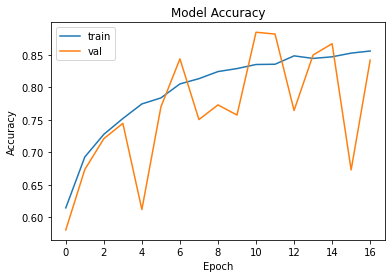

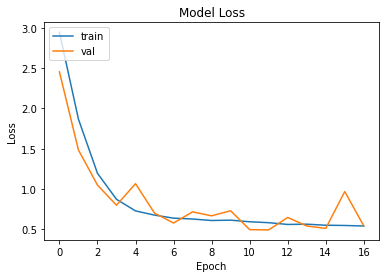

157/157 [==============================] - 27s 171ms/step - loss: 0.4764 - accuracy: 0.8876
Test accuracy: 0.8876000046730042


In [61]:
history7 = model7.fit(train_data, epochs=25, steps_per_epoch=len(X_train) // 32, validation_data=(X_val, y_val), callbacks=[early_stopping])

plt.plot(history7.history['accuracy'])
plt.plot(history7.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

test_loss, test_acc = model7.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

### Comments on model7 performances

`model7` showed a significant improvement in validation accuracy compared to the previous model, reaching 88.18% at epoch 12. This improvement can be attributed to the deeper architecture and the additional Dense layer with 1024 units, which allowed the model to learn more complex and hierarchical features. However, there was a slight increase in training time due to the increased model complexity.

Despite the increase in validation accuracy, we still observe some fluctuation in the validation accuracy and loss during training. This may indicate that the model could benefit from further fine-tuning or the addition of more regularization techniques to achieve a more stable performance.


## 8th experiment: model8

`model8` introduces a `GlobalAveragePooling2D` layer instead of the `Flatten` layer used in the previous model. Global average pooling reduces the spatial dimensions of the feature maps by computing the average value of each channel, resulting in a smaller and more compact representation. This change helps reduce the total number of parameters, which can help prevent overfitting and improve training efficiency.


In [ ]:
dropout_rate = 0.1
learning_rate = 0.0005
l2_lambda = 0.001

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_data = train_datagen.flow(X_train, y_train)

model8 = Sequential([
    Conv2D(32, (3, 3), kernel_regularizer=l2(l2_lambda), input_shape=(150, 150, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(64, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(128, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(256, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(512, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Dense(1024, kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

model8.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Epoch 1/25
468/468 [==============================] - 415s 879ms/step - loss: 1.8028 - accuracy: 0.6037 - val_loss: 1.4477 - val_accuracy: 0.6890
Epoch 2/25
468/468 [==============================] - 368s 785ms/step - loss: 1.2654 - accuracy: 0.6928 - val_loss: 1.0252 - val_accuracy: 0.7302
Epoch 3/25
468/468 [==============================] - 364s 778ms/step - loss: 0.9418 - accuracy: 0.7273 - val_loss: 0.9906 - val_accuracy: 0.6788
Epoch 4/25
468/468 [==============================] - 369s 788ms/step - loss: 0.7643 - accuracy: 0.7545 - val_loss: 0.6467 - val_accuracy: 0.7930
Epoch 5/25
468/468 [==============================] - 365s 780ms/step - loss: 0.6657 - accuracy: 0.7754 - val_loss: 0.9532 - val_accuracy: 0.6140
Epoch 6/25
468/468 [==============================] - 384s 821ms/step - loss: 0.6182 - accuracy: 0.7894 - val_loss: 0.9273 - val_accuracy: 0.6882
Epoch 7/25
468/468 [==============================] - 393s 839ms/step - loss: 0.5863 - accuracy: 0.8024 - val_loss: 0.6720 -

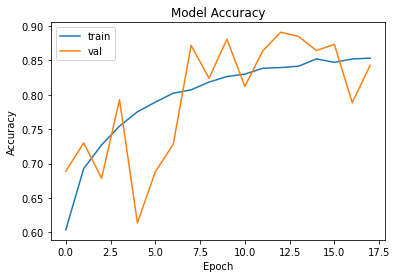

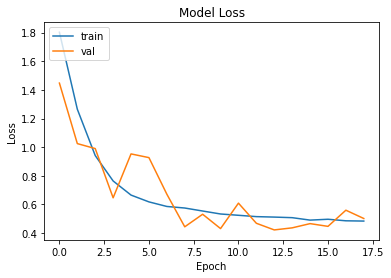

157/157 [==============================] - 38s 239ms/step - loss: 0.4200 - accuracy: 0.8906
Test accuracy: 0.8906000256538391


In [18]:
history8 = model8.fit(train_data, epochs=25, steps_per_epoch=len(X_train) // 32, validation_data=(X_val, y_val), callbacks=[early_stopping])

plt.plot(history8.history['accuracy'])
plt.plot(history8.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

test_loss, test_acc = model8.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

### Comments on Model8 Performances

`model8` displays a consistent improvement in validation accuracy, peaking at 89.10% in epoch 13. When compared to Model7, which achieved a peak validation accuracy of 88.18% at epoch 12, Model8 demonstrates a better performance.
However, like `model7`, `model8` also experiences fluctuations in validation accuracy and loss, indicating potential benefits from further fine-tuning or additional regularization techniques for more stable performance.


## 9th experiment: model9

The `model9` introduces several changes compared to the previous one:

1. **Reduced dropout rate**: The dropout_rate is reduced to 0.1
2. **Lower learning rate**: The learning_rate is lowered to 0.0005, which may help the model converge more smoothly and find better local minima.
3. **L2 regularization**: L2 regularization is added to the convolutional and dense layers with a l2_lambda value of 0.001.
4. **Increased batch size**: The batch_size is increased to 64, which can provide a better estimate of the gradient and potentially accelerate training.

In [ ]:
dropout_rate = 0.1
learning_rate = 0.0005
l2_lambda = 0.001
batch_size = 64

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_data = train_datagen.flow(X_train, y_train, batch_size=batch_size)

model9 = Sequential([
    Conv2D(32, (3, 3), kernel_regularizer=l2(l2_lambda), input_shape=(150, 150, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(64, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(128, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(256, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(512, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Dense(1024, kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

model9.compile(optimizer=RMSprop(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)


Epoch 1/25
234/234 [==============================] - 595s 3s/step - loss: 1.7696 - accuracy: 0.6058 - val_loss: 1.3339 - val_accuracy: 0.6112
Epoch 2/25
234/234 [==============================] - 493s 2s/step - loss: 1.0684 - accuracy: 0.6925 - val_loss: 1.1139 - val_accuracy: 0.6224
Epoch 3/25
234/234 [==============================] - 527s 2s/step - loss: 0.7886 - accuracy: 0.7357 - val_loss: 0.6417 - val_accuracy: 0.8040
Epoch 4/25
234/234 [==============================] - 557s 2s/step - loss: 0.6767 - accuracy: 0.7616 - val_loss: 0.7386 - val_accuracy: 0.7284
Epoch 5/25
234/234 [==============================] - 416s 2s/step - loss: 0.6262 - accuracy: 0.7766 - val_loss: 0.7631 - val_accuracy: 0.7370
Epoch 6/25
234/234 [==============================] - 361s 2s/step - loss: 0.5887 - accuracy: 0.7956 - val_loss: 0.5580 - val_accuracy: 0.8152
Epoch 7/25
234/234 [==============================] - 367s 2s/step - loss: 0.5603 - accuracy: 0.8103 - val_loss: 0.4745 - val_accuracy: 0.8530

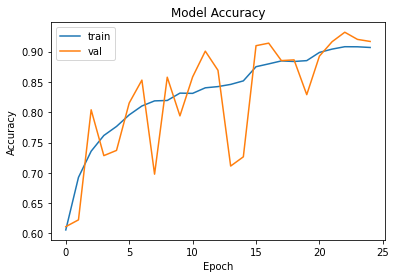

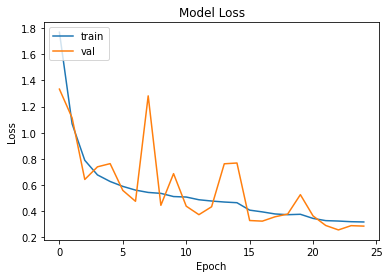

157/157 [==============================] - 25s 157ms/step - loss: 0.2785 - accuracy: 0.9226
Test accuracy: 0.9225999712944031


In [11]:
history9 = model9.fit(train_data, epochs=25, steps_per_epoch=len(X_train) // batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping, lr_scheduler])

plt.plot(history9.history['accuracy'])
plt.plot(history9.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history9.history['loss'])
plt.plot(history9.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

test_loss, test_acc = model9.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


### Comments on Model9 Performances

`model9` shows a clear improvement over `model8`. The highest validation accuracy achieved by Model9 is 93.20% at epoch 23, compared to Model8's peak validation accuracy of 89.10% at epoch 13. This indicates that the adjustments made in Model9 have effectively improved the model's performance in capturing the underlying patterns in the data.

Moreover, Model9 appears to have a more stable performance, with smaller fluctuations in validation accuracy and loss, thanks to the inclusion of L2 regularization and the reduced dropout rate. This suggests that Model9 has a better balance between learning capacity and generalization, leading to a more robust and accurate model.
However I think that the model could do even better if trained for more epochs.


## 10th experiment: Model10
In `model10`, the number of epochs has been increased from 25 to 60, allowing the model more time to learn from the dataset. This change aims to explore whether additional training time could further improve the `model9`'s performance.

All other aspects of `model10` remain the same as in `model9`, including the architecture, L2 regularization, dropout rates, and data augmentation.


In [ ]:
dropout_rate = 0.1
learning_rate = 0.0005
l2_lambda = 0.001
batch_size = 64

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_data = train_datagen.flow(X_train, y_train, batch_size=batch_size)

model10 = Sequential([
    Conv2D(32, (3, 3), kernel_regularizer=l2(l2_lambda), input_shape=(150, 150, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(64, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(128, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(256, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(512, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Dense(1024, kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

model10.compile(optimizer=RMSprop(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

Epoch 1/60
234/234 [==============================] - 414s 2s/step - loss: 1.7682 - accuracy: 0.6058 - val_loss: 1.6383 - val_accuracy: 0.5006
Epoch 2/60
234/234 [==============================] - 385s 2s/step - loss: 1.1040 - accuracy: 0.6843 - val_loss: 1.1292 - val_accuracy: 0.5112
Epoch 3/60
234/234 [==============================] - 380s 2s/step - loss: 0.8102 - accuracy: 0.7356 - val_loss: 0.7029 - val_accuracy: 0.7732
Epoch 4/60
234/234 [==============================] - 378s 2s/step - loss: 0.6854 - accuracy: 0.7642 - val_loss: 1.4942 - val_accuracy: 0.5476
Epoch 5/60
234/234 [==============================] - 368s 2s/step - loss: 0.6377 - accuracy: 0.7759 - val_loss: 0.6413 - val_accuracy: 0.7554
Epoch 6/60
234/234 [==============================] - 411s 2s/step - loss: 0.5859 - accuracy: 0.7979 - val_loss: 0.8585 - val_accuracy: 0.6828
Epoch 7/60
234/234 [==============================] - 533s 2s/step - loss: 0.5654 - accuracy: 0.8036 - val_loss: 0.5300 - val_accuracy: 0.8102

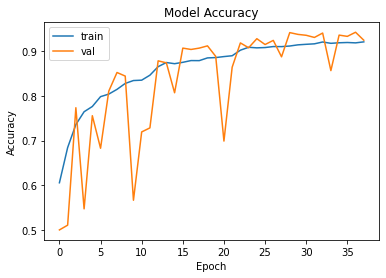

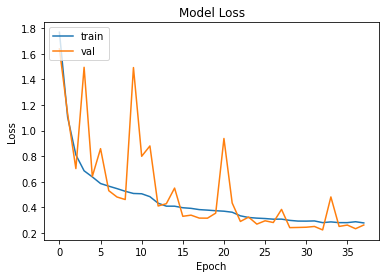

157/157 [==============================] - 34s 213ms/step - loss: 0.2293 - accuracy: 0.9418
Test accuracy: 0.9417999982833862


In [67]:
history10 = model10.fit(train_data, epochs=60, steps_per_epoch=len(X_train) // batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping, lr_scheduler])

plt.plot(history10.history['accuracy'])
plt.plot(history10.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history10.history['loss'])
plt.plot(history10.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

test_loss, test_acc = model10.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

### Comments on Model10 Performances
The final model, model10, demonstrates a strong overall performance in terms of accuracy and loss. It achieved a validation accuracy of 94.08% at epoch 29, which shows that longer training improved its results, as expected. Compared to previous models, model10's validation accuracy consistently increased or remained relatively stable over the epochs. Its accuracy improved gradually over the epochs, without any sign of overfitting. Based on these characteristics, model10 is a satisfying final model for this task.

## Final model

After achieving a good level of accuracy and resolving the issues of overfitting and stability, we are ready to save the final model: Model10.

In [68]:
model10.save('C:/Users/lucad/OneDrive/Desktop/MACHINE LEARNING/models/model10.h5')

In [9]:
model10 = load_model('C:/Users/lucad/OneDrive/Desktop/MACHINE LEARNING/models/model10.h5')

### Test set accuracy
Let's evaluate the performance of the final model on the test set and analyze the types of images that were misclassified.

In [10]:
test_loss, test_acc = model10.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

157/157 [==============================] - 28s 171ms/step - loss: 0.2293 - accuracy: 0.9418
Test accuracy: 0.9417999982833862


The test accuracy seems to be pretty good for this task.

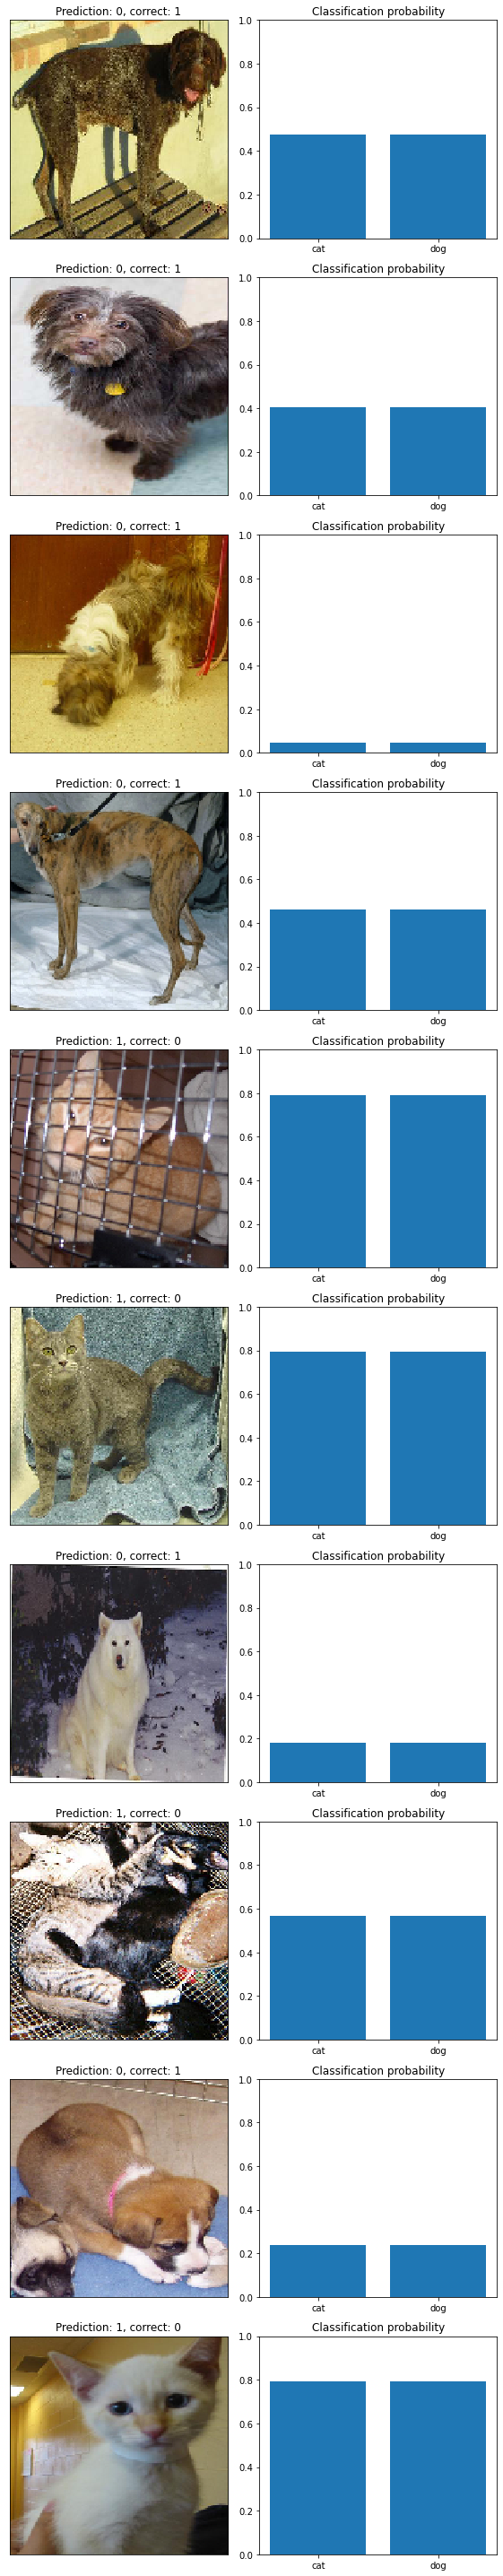

In [12]:
y_pred = model10.predict(X_test)

y_pred_labels = np.round(y_pred).astype(int).reshape(-1)

incorrect_indices = np.nonzero(y_pred_labels != y_test)[0]

n_show = min(len(incorrect_indices), 10)  
fig, axes = plt.subplots(n_show, 2, figsize=(8, 4 * n_show), gridspec_kw={'width_ratios': [3, 3]})

for i, incorrect_idx in enumerate(incorrect_indices[:n_show]):
    axes[i, 0].imshow(X_test[incorrect_idx], cmap='gray', interpolation='none')
    axes[i, 0].set_title("Prediction: {}, correct: {}".format(y_pred_labels[incorrect_idx], y_test[incorrect_idx]))
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])
    
    axes[i, 1].bar(range(2), y_pred[incorrect_idx], tick_label=['cat', 'dog'])
    axes[i, 1].set_title("Classification probability")
    axes[i, 1].set_ylim([0, 1])

fig.tight_layout()
plt.show()


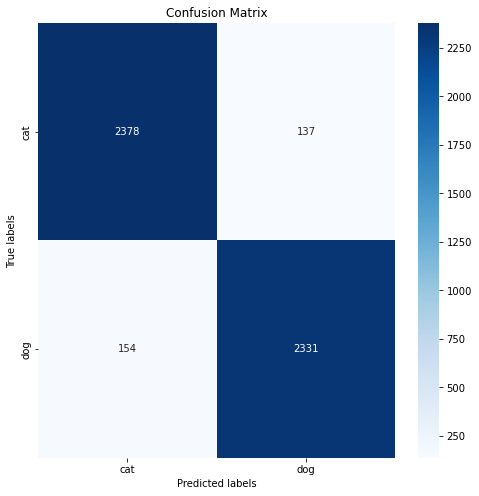

In [15]:
y_pred_labels = np.round(y_pred).astype(int).reshape(-1)
conf_mat = confusion_matrix(y_test, y_pred_labels)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=['cat', 'dog'], yticklabels=['cat', 'dog'])
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()


We can observe that while some misclassified images were indeed challenging due to factors such as poor quality or unusual positions, others appeared to be easily classifiable. Furthermore, it is worth noting that the misclassified images had similar classification probabilities. I think there is potential for improvement through the use of deeper CNN architectures and increased time and computational resources.

### Let's test it on friends' pets
Here I load the images of some friends' cats and dogs, including my own cat Milton.

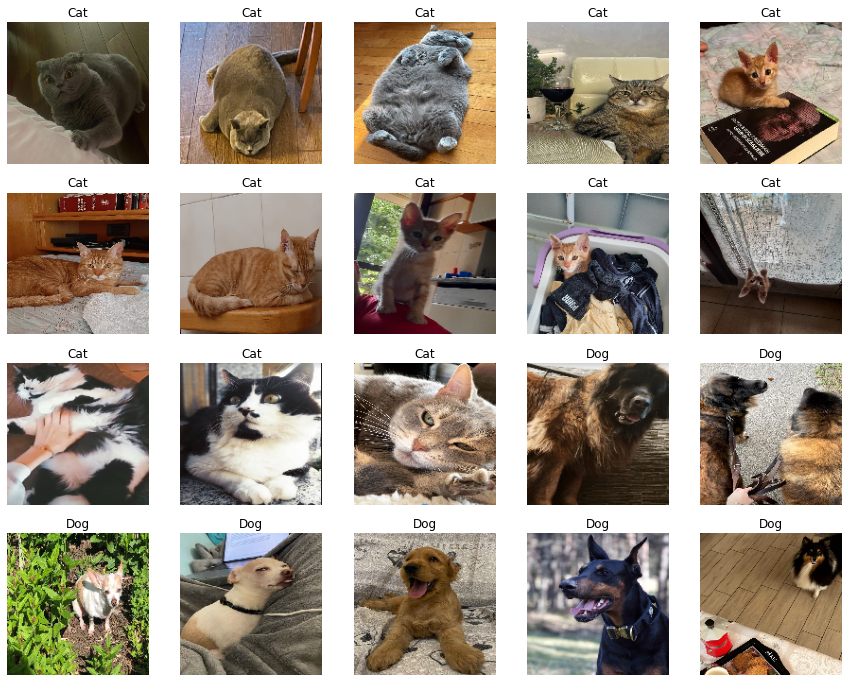

In [41]:
new_images_dir = r'C:\Users\lucad\OneDrive\Desktop\MACHINE LEARNING\new images'

new_images = []
new_labels = []
for new_file in os.listdir(new_images_dir):
    if new_file.startswith('0'):
        label = 0  # cat
    else:
        label = 1  # dog
    try:
        new_img = load_img(os.path.join(new_images_dir, new_file), target_size=(150, 150))
    except:
        print("Cannot open image file:", file)
        continue
    new_img_array = img_to_array(new_img)
    new_img_array = new_img_array / 255.0  
    new_images.append(new_img_array)
    new_labels.append(label)

new_images = np.array(new_images)
new_labels = np.array(new_labels)

fig, axs = plt.subplots(4, 5, figsize=(15, 12))
for i in range(4):
    for j in range(5):
        index = i * 5 + j
        axs[i, j].imshow(new_images[index])
        axs[i, j].axis('off')
        if new_labels[index] == 0:
            axs[i, j].set_title('Cat')
        else:
            axs[i, j].set_title('Dog')
        if index == len(new_images) - 1:
            break
plt.show()



Let's classify them!

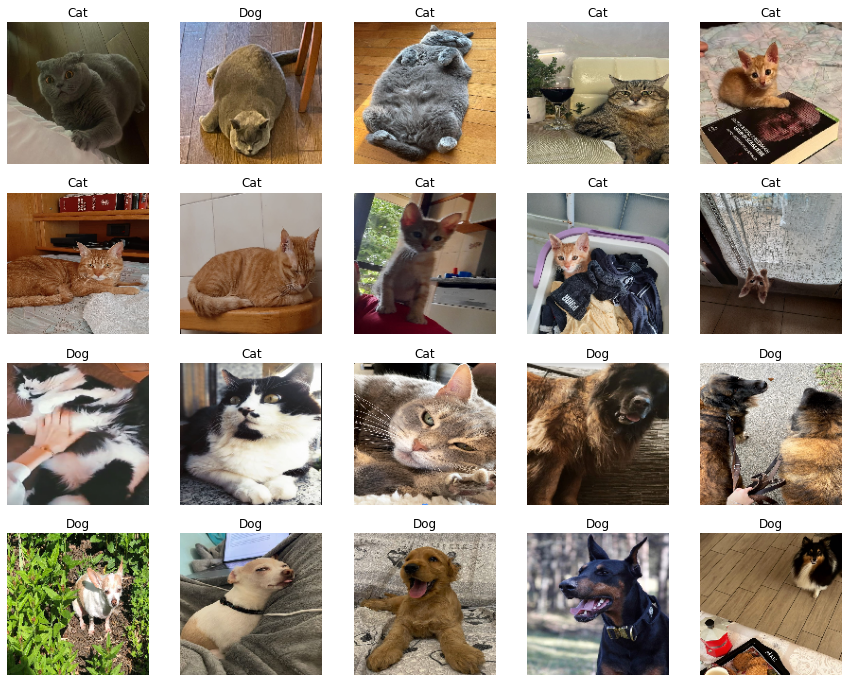

In [42]:
new_predictions = model10.predict(new_images)

num_images = len(new_images)
num_cols = 5
num_rows = num_images // num_cols + (1 if num_images % num_cols != 0 else 0)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*3))
for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        if index >= num_images:
            break
        axs[i, j].imshow(new_images[index])
        axs[i, j].axis('off')
        if new_predictions[index] < 0.5:
            axs[i, j].set_title('Cat')
        else:
            axs[i, j].set_title('Dog')
plt.show()



There are only two mistakes: the most difficult pictures.

## Cross validation
Finally, to compute our risk estimates for the final model, we used 5-fold cross-validation with the zero-one loss (as required). Model10 was recreated identically, including early stopping and data augmentation.

For each fold, the data was split into training and validation sets, and the model was trained on the training set while monitoring the validation loss. The model was then used to predict the validation labels, and the zero-one loss was calculated as the percentage of misclassified images. This process was repeated for all five folds, and the mean zero-one loss across all folds was calculated as our final risk estimate.

In [24]:
dropout_rate = 0.1
learning_rate = 0.0005
l2_lambda = 0.001
batch_size = 64

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_data = train_datagen.flow(X_train, y_train, batch_size=batch_size)

model10_CV = Sequential([
    Conv2D(32, (3, 3), kernel_regularizer=l2(l2_lambda), input_shape=(150, 150, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(64, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(128, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(256, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(dropout_rate),
    Conv2D(512, (3, 3), kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Dense(1024, kernel_regularizer=l2(l2_lambda)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

model10_CV.compile(optimizer=RMSprop(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)


In [25]:
# Combine train and validation data
X_combined = np.concatenate((X_train, X_val))
y_combined = np.concatenate((y_train, y_val))

# Divide the combined data into 5 folds
n_folds = 5
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

zero_one_losses = []

fold_counter = 1

for train_index, val_index in kfold.split(X_combined, y_combined):
    print(f"Training Fold {fold_counter} of {n_folds}...")
    X_train_fold, X_val_fold = X_combined[train_index], X_combined[val_index]
    y_train_fold, y_val_fold = y_combined[train_index], y_combined[val_index]

    train_data = train_datagen.flow(X_train_fold, y_train_fold, batch_size=batch_size)

    history10_CV = model10_CV.fit(train_data, epochs=60, steps_per_epoch=len(X_train_fold) // batch_size, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping, lr_scheduler], verbose=1)

    y_val_pred = model10_CV.predict(X_val_fold)
    y_val_pred = np.round(y_val_pred).flatten()

    zero_one_loss = 1 - accuracy_score(y_val_fold, y_val_pred)
    zero_one_losses.append(zero_one_loss)
    print(f"Fold {fold_counter} Zero-One Loss: {zero_one_loss:.4f}")

    fold_counter += 1

# Calculate the average zero-one loss across all folds
mean_zero_one_loss = np.mean(zero_one_losses)
print(f"Mean Zero-One Loss: {mean_zero_one_loss:.4f}")



Training Fold 1 of 5...
Epoch 1/60
249/249 [==============================] - 442s 2s/step - loss: 1.7509 - accuracy: 0.5926 - val_loss: 1.4367 - val_accuracy: 0.4997
Epoch 2/60
249/249 [==============================] - 416s 2s/step - loss: 1.0784 - accuracy: 0.6966 - val_loss: 1.2827 - val_accuracy: 0.5205
Epoch 3/60
249/249 [==============================] - 449s 2s/step - loss: 0.8098 - accuracy: 0.7367 - val_loss: 0.6659 - val_accuracy: 0.7955
Epoch 4/60
249/249 [==============================] - 442s 2s/step - loss: 0.6850 - accuracy: 0.7631 - val_loss: 0.8781 - val_accuracy: 0.6472
Epoch 5/60
249/249 [==============================] - 421s 2s/step - loss: 0.6208 - accuracy: 0.7812 - val_loss: 0.6043 - val_accuracy: 0.7905
Epoch 6/60
249/249 [==============================] - 432s 2s/step - loss: 0.5801 - accuracy: 0.7997 - val_loss: 0.8608 - val_accuracy: 0.6925
Epoch 7/60
249/249 [==============================] - 396s 2s/step - loss: 0.5585 - accuracy: 0.8067 - val_loss: 0.514

The risk estimates for the final model using 5-fold cross-validation with the zero-one loss is 0.0431. I think it is a satisfactory result!